In [1]:
from transformers import Mask2FormerImageProcessor
import torchvision.transforms as T
import kornia.augmentation as K
import torch.nn.functional as F
from einops import rearrange
import torch
from torch.utils.data import DataLoader
from torchgeo.datamodules.utils import dataset_split
import numpy as np
import matplotlib.pyplot as plt
import evaluate
from PIL import Image
from tqdm.auto import tqdm
metric = evaluate.load("mean_iou")

In [2]:
img0 = Image.open('IMG_PNEO3_202401.TIF')
img1 = Image.open('IMG_PNEO4_202302.TIF')

# img1 = Image.open('IMG_PHR1B_20220308.TIF')
# img2 = Image.open('IMG_PHR1B_20220618.TIF')
scale_factor = 0.3 / 0.5
new_width = int(img1.width * scale_factor)
new_height = int(img1.height * scale_factor)

# Resize the image using PyTorch
resize_transform = T.Compose([
    # T.Resize((new_height, new_width)),
    T.ToTensor()
])
tensor_image0 = resize_transform(img0)
tensor_image1 = resize_transform(img1)

In [9]:
model = torch.load("Mask2_B_tiny_40.pt", map_location="cpu")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")
model = model.to(device)

In [10]:
preprocessor = Mask2FormerImageProcessor(ignore_index=-100,
                                         reduce_labels=False,
                                         do_resize=False,
                                         do_rescale=False,
                                         do_normalize=False,)

In [18]:
sample = K.AugmentationSequential(
    K.RandomCrop((512, 512), p=1, keepdim=False),
    data_keys=['input', 'mask'],
    )(tensor_image0[:3].unsqueeze(0), tensor_image1[:3].unsqueeze(0))


sample[0] = rearrange(sample[0], '() c h w -> c h w')
sample[1] = rearrange(sample[1], '() c h w -> c h w')

model.eval()
with torch.no_grad():
    output0 = model(pixel_values=sample[0].to(device).unsqueeze(0))
    output1 = model(pixel_values=sample[1].to(device).unsqueeze(0))
mask_pred0 = preprocessor.post_process_semantic_segmentation(output0,
                                                             target_sizes=[[512, 512]])
mask_pred1 = preprocessor.post_process_semantic_segmentation(output1,
                                                             target_sizes=[[512, 512]])

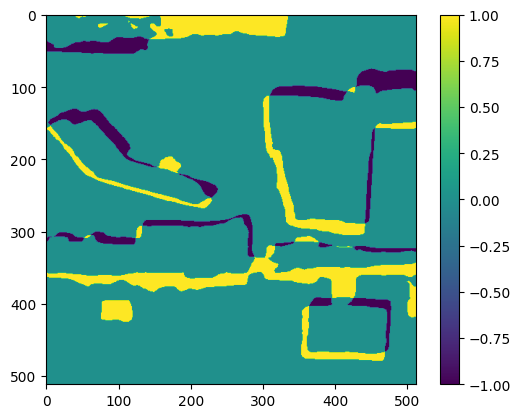

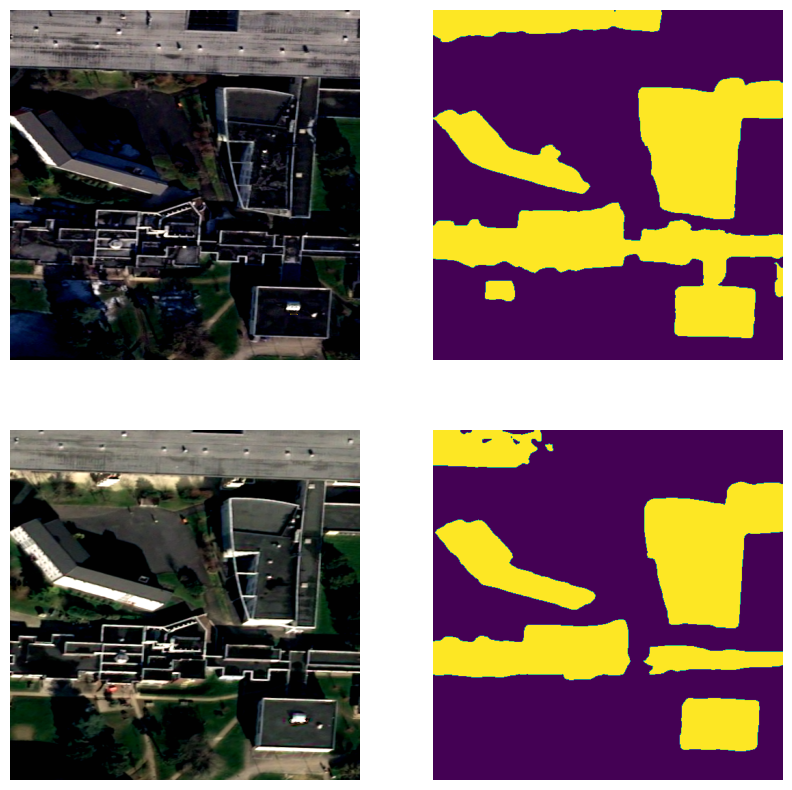

In [21]:
compare = plt.imshow(mask_pred0[0].to('cpu')-mask_pred1[0].to('cpu'))
plt.colorbar(compare)
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(sample[0].permute(1, 2, 0))
axs[0, 1].imshow(mask_pred0[0].to('cpu'))
# image_bar = axs[0, 1].imshow(mask_pred0[0].to('cpu'), cmap, vmin=0, vmax=16)

axs[1, 0].imshow(sample[1].permute(1, 2, 0))
axs[1, 1].imshow(mask_pred1[0].to('cpu'))
for ax in axs.flat:
    ax.axis('off')

# cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # x, y, width, height (in figure coordinate)
# fig.colorbar(image_bar, cax=cbar_ax)
# cbar = fig.colorbar(image_bar, ax=axs[:, 1], ticks = range(len(DFC2022.colormap)))
# fig.subplots_adjust(hspace=0, wspace=0, right=0.85)
plt.show()
fig.savefig("X_compare.jpg")
